## Working with the dataset of [Sea ice drift tracks from the Distributed Network of autonomous buoys deployed during the Multidisciplinary drifting Observatory for the Study of Arctic Climate (MOSAiC) expedition 2019 - 2021](https://arcticdata.io/catalog/view/doi:10.18739/A2KP7TS83). 

A notebook from the [Clouddrift project](https://github.com/Cloud-Drift).

The citation for this dataset is: *Angela Bliss, Jennifer Hutchings, Philip Anderson, Philipp Anhaus, Hans Jakob Belter, Jørgen Berge, Vladimir Bessonov, Bin Cheng, Sylvia Cole, Dave Costa, Finlo Cottier, Christopher J Cox, Pedro R De La Torre, Dmitry V Divine, Gilbert Emzivat, Ying-Chih Fang, Steven Fons, Michael Gallagher, Maxime Geoffrey, Mats A Granskog, ... Guangyu Zuo. (2022). Sea ice drift tracks from the Distributed Network of autonomous buoys deployed during the Multidisciplinary drifting Observatory for the Study of Arctic Climate (MOSAiC) expedition 2019 - 2021. Arctic Data Center. [doi:10.18739/A2KP7TS83](https://arcticdata.io/catalog/view/doi:10.18739/A2KP7TS83).*

This dataset from the MOSAiC experiment has been aggregated as a ragged array dataset as part of the [Datasets module](https://cloud-drift.github.io/clouddrift/api.html#module-clouddrift.datasets) of the [clouddrift python library](https://github.com/Cloud-Drift/clouddrift). We show in this notebook how to load the dataset directly from clouddrift and showcase a couple of functionality of clouddrift.

## 0. Loading some needed Python libraries

In [1]:
# import needed libraries
import clouddrift as cd
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs

## 1. Getting the data

If the dataset is not already part of your local clouddrift library of datasets (located by default in your home directory under `~/.clouddrift/data/mosaic.nc`), the *data accessor* function `mosaic()` will download all individual files and form a single file with the data organized as ragged arrays.

In [2]:
ds = cd.datasets.mosaic()
ds

/Users/selipot/.clouddrift/data/mosaic.nc not found; download from upstream repository.


<xarray.Dataset>
Dimensions:                     (obs: 1926226, traj: 216)
Coordinates:
  * time                        (obs) datetime64[ns] 2019-10-14T06:08:24 ... ...
  * id                          (traj) object '2019F4' '2019I4' ... '2020P236'
Dimensions without coordinates: obs, traj
Data variables: (12/19)
    latitude                    (obs) float64 84.78 84.77 84.76 ... 82.89 82.89
    longitude                   (obs) float64 134.5 134.5 134.4 ... 24.79 24.78
    Deployment Leg              (traj) int64 1 1 1 1 1 1 1 1 ... 5 5 5 5 5 5 5 5
    DN Station ID               (traj) object 'CO1' 'CO1' ... 'P117' 'P118'
    IMEI                        (traj) object '300025060016190' ... '30023406...
    Deployment Date             (traj) datetime64[ns] 2019-10-14 ... 2020-09-23
    ...                          ...
    Buoy Type                   (traj) object 'Flux Buoy' ... 'SVP'
    Manufacturer                (traj) object 'Naval Postgraduate School' ......
    Model                       (traj) object 'Autonomous Ocean Flux Buoy' .....
    PI                          (traj) object 'Stanton' ... 'Hoppmann; EUMETNET'
    Data Authors                (traj) object 'Tim Stanton; Bill Shaw' ... 'M...
    rowsize                     (traj) int64 1549 1207 457 ... 6044 5933 5821

Because the dataset is organized as a ragged array (see diagram below), we need to define the indices of each row corresponding to each sea ice track:

<img src="ragged_array.png" alt="Drawing" style="width: 1000px;"/>

In [3]:
# define the row index
row_index = np.insert(np.cumsum(ds["rowsize"].values), 0, 0) # define row index

We can now simply plot the geographical trajectory of let's say the sea ice track in row index 10:

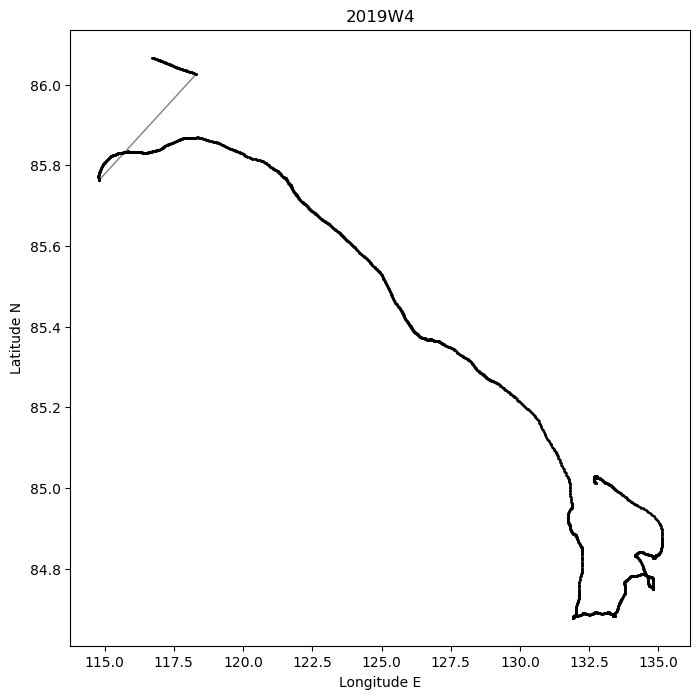

In [4]:
j = 10
row = slice(row_index[j], row_index[j+1]) # define a slice for the j-th row

plt.figure(figsize=(8,8))
plt.plot(ds.longitude[row],ds.latitude[row],marker='o',markerfacecolor='k',markeredgecolor='none',markersize=2,linewidth=1,color=(0.5,0.5,0.5))
plt.title(ds.id[j].values)
plt.xlabel('Longitude E')
plt.ylabel('Latitude N');

## 2. Doing some simple analyses of the data

We now showcase a couple of functionalities of clouddrift to analyze Lagrangian data: calculation of Lagrangian velocity from positions with `velocity_from_position`, as well application of a function on each row of a ragged array thanks to `apply_ragged`. These two functions are available from the `clouddrift.analysis` module.

In [5]:
from clouddrift.analysis import apply_ragged, velocity_from_position

Let's start by calculating simply the zonal and meridional velocities from the Lagrangian tracks using `velocity_from_position`. This function returns velocity components in meter per unit of time provided (here nanosecond from the python `datetime64[ns]` type) so we eventually multiply the outputs by 1e9 to get the speed in m/s when assigning that new variable to the dataset. To make sure we apply the velocity calculation individually to each row of the ragged array, we pass that function to the `apply_ragged` function as follows:

In [6]:
# calculate the velocity
u, v = apply_ragged(velocity_from_position,[ds.longitude,ds.latitude,ds.time],ds.rowsize)

# add the u and v variables to dataset. We also add the speed variable for convenience
ds["u"]=(['obs'],  1e9*u)
ds["v"]=(['obs'],  1e9*v)
ds["speed"] = (['obs'], ((ds.u**2+ds.v**2)**0.5).data)
ds

<xarray.Dataset>
Dimensions:                     (obs: 1926226, traj: 216)
Coordinates:
  * time                        (obs) datetime64[ns] 2019-10-14T06:08:24 ... ...
  * id                          (traj) object '2019F4' '2019I4' ... '2020P236'
Dimensions without coordinates: obs, traj
Data variables: (12/22)
    latitude                    (obs) float64 84.78 84.77 84.76 ... 82.89 82.89
    longitude                   (obs) float64 134.5 134.5 134.4 ... 24.79 24.78
    Deployment Leg              (traj) int64 1 1 1 1 1 1 1 1 ... 5 5 5 5 5 5 5 5
    DN Station ID               (traj) object 'CO1' 'CO1' ... 'P117' 'P118'
    IMEI                        (traj) object '300025060016190' ... '30023406...
    Deployment Date             (traj) datetime64[ns] 2019-10-14 ... 2020-09-23
    ...                          ...
    PI                          (traj) object 'Stanton' ... 'Hoppmann; EUMETNET'
    Data Authors                (traj) object 'Tim Stanton; Bill Shaw' ... 'M...
    rowsize                     (traj) int64 1549 1207 457 ... 6044 5933 5821
    u                           (obs) float64 -0.04124 -0.07308 ... -0.0356
    v                           (obs) float64 -0.1001 -0.07563 ... -0.08962
    speed                       (obs) float64 0.1082 0.1052 ... 0.09643 0.09643

We can now visualize these new results by redrawing the earlier plot but displaying the speed of the Lagrangian "drift" as a color along the track:

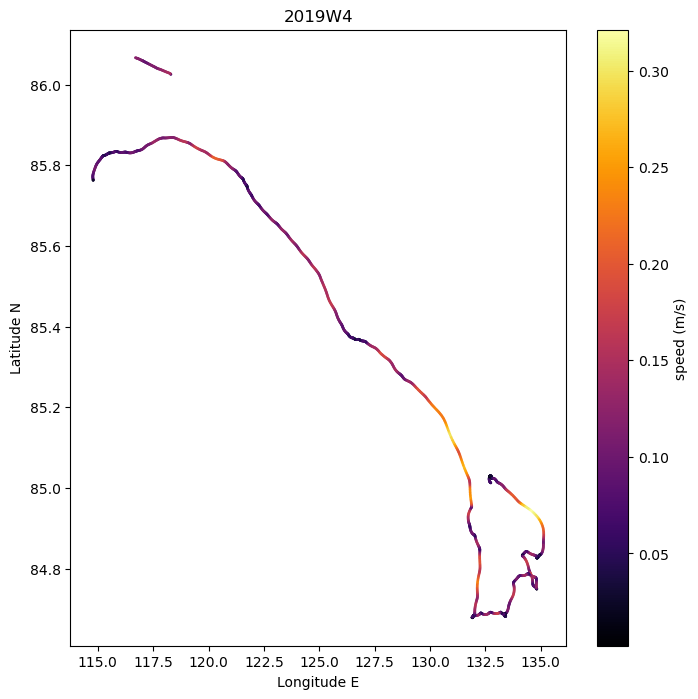

In [7]:
j = 10
sli = slice(row_index[j], row_index[j+1]) # define a slice for the index 10 row

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
pcm1 = ax.scatter(ds.longitude[sli], ds.latitude[sli],s=1,c=ds.speed[sli],cmap='inferno',edgecolor='face')
cb = fig.colorbar(pcm1,ax=ax)
cb.set_label('speed (m/s)')
ax.set_ylabel('Latitude N')
ax.set_xlabel('Longitude E')
ax.set_title(ds.id[j].values);

We can now plot a map of all trajectories. Here is one solution below but you may know a better projection for the area:

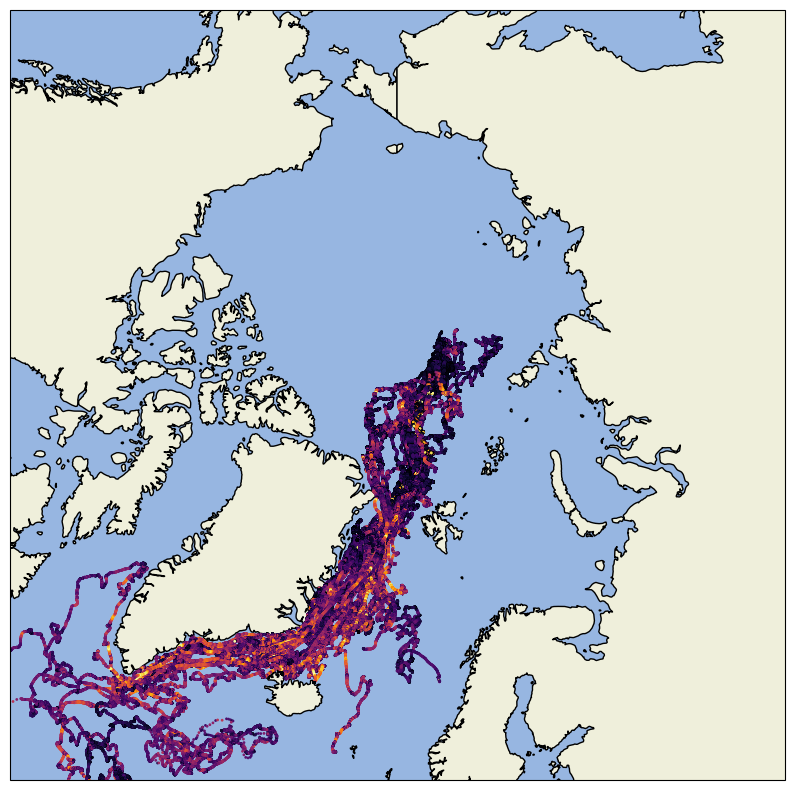

In [8]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111,projection=ccrs.NorthPolarStereo())
ax.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN, zorder=1)
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

# the following application of apply_ragged crashes my kernel. Why? 
#apply_ragged(ax.plot,[ds.longitude,ds.latitude],ds["count"].values,transform=ccrs.PlateCarree());

for j in range(1,len(ds.traj)):
    row = slice(row_index[j], row_index[j+1])
    # plot each trajectory of a different color
    #ax.plot(ds.longitude[row],ds.latitude[row],transform=ccrs.PlateCarree())
    # plot all trajectory color by speed
    ax.scatter(ds.longitude[row], ds.latitude[row],s=1,c=ds.speed[row],transform=ccrs.PlateCarree(),cmap='inferno',edgecolor='face')


Here is another plot of all the sea ice track speeds as a function of time that provides an overview of the data. Note that we offset each curve by 0.1 m/s:

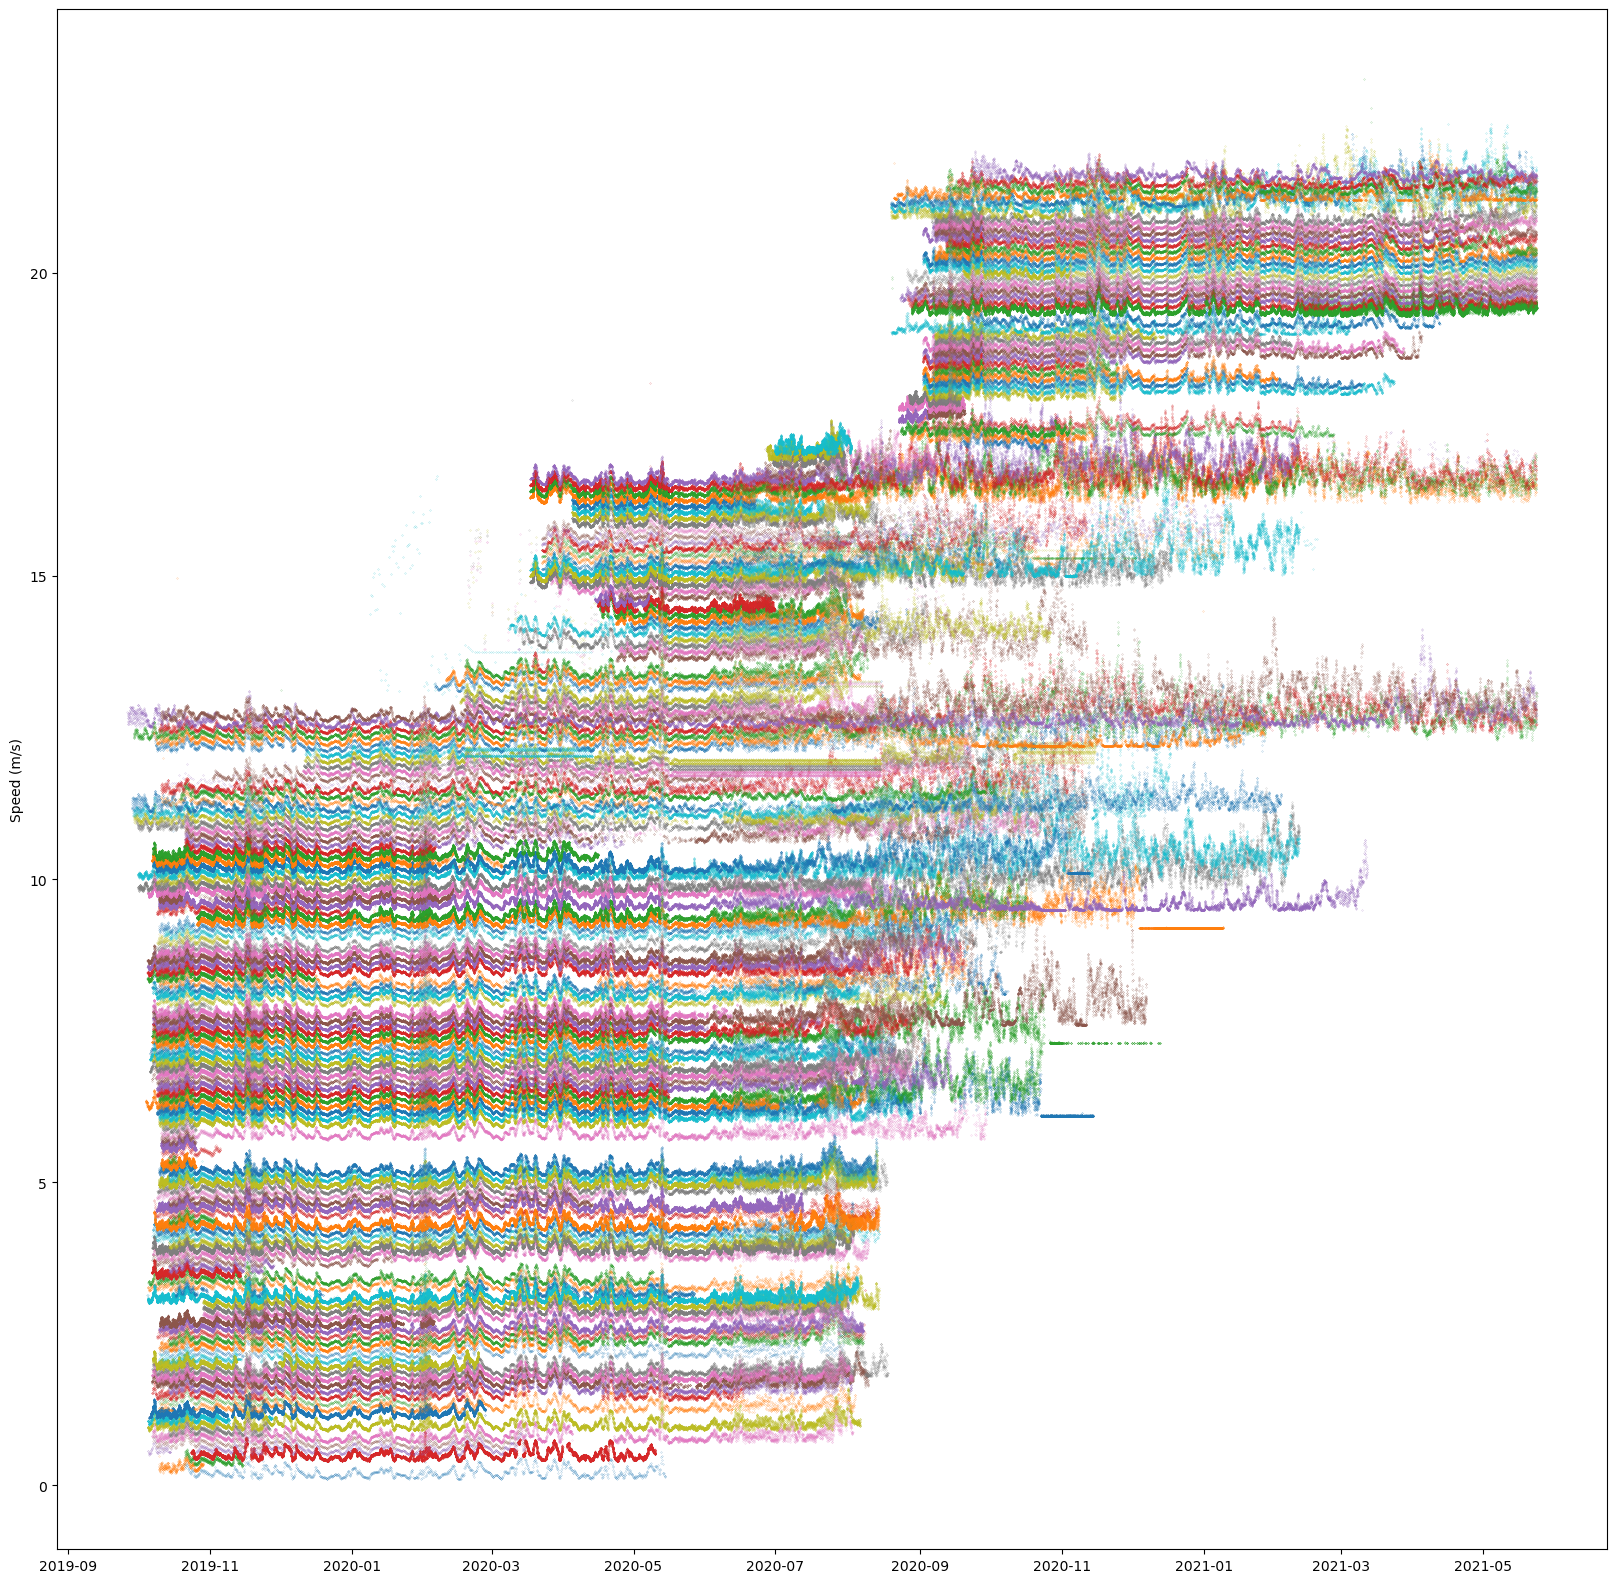

In [9]:
j = 10
sli = slice(row_index[j], row_index[j+1]) # define a slice for the index 10 row

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Speed (m/s)')
for j in range(1,len(ds.traj)):
    row = slice(row_index[j], row_index[j+1])
    ax.plot(ds.time[row],ds.speed[row] + 0.1*j,marker='.',linestyle='none',markersize=0.25)